# Project- Capstone: Deep Learning prediction of COVID-19 radiological imaging for improving the accuracy of diagnosis

## Muhammad Tahir;
## Data Science Immersive @ General Assembly - April-2021

## Part-1- Imports and Reading images

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

# For reproducibility
np.random.seed(42)

from glob import glob
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report

bce = tf.keras.losses.BinaryCrossentropy()
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

In [2]:
test_image = load_img('./images/ARDSSevere.png', color_mode = 'grayscale')
test_image

In [3]:
image_array = img_to_array(test_image)

In [4]:
image_array

array([[[224.],
        [224.],
        [224.],
        ...,
        [224.],
        [224.],
        [224.]],

       [[  0.],
        [  0.],
        [  0.],
        ...,
        [  0.],
        [  0.],
        [  0.]],

       [[152.],
        [147.],
        [136.],
        ...,
        [  7.],
        [  5.],
        [  6.]],

       ...,

       [[ 20.],
        [ 23.],
        [ 23.],
        ...,
        [ 87.],
        [ 85.],
        [ 84.]],

       [[ 21.],
        [ 22.],
        [ 26.],
        ...,
        [ 84.],
        [ 86.],
        [ 82.]],

       [[ 22.],
        [ 21.],
        [ 23.],
        ...,
        [ 80.],
        [ 81.],
        [ 78.]]], dtype=float32)

In [5]:
image_array.squeeze().shape

(631, 790)

In [6]:
normalized_image = image_array / 255
plt.imshow(normalized_image)

In [7]:
# resize image
resize_image = load_img('./images/ARDSSevere.png', target_size=(64, 64))
resize_image

In [8]:
res_image = img_to_array(resize_image)

In [9]:
res_image[:,:,2]

array([[123., 101.,  78., ...,  29.,  10.,  11.],
       [141., 120., 117., ..., 101.,  95.,  91.],
       [151., 142., 136., ...,  56.,  54.,  52.],
       ...,
       [128.,  82., 121., ..., 125., 118.,  91.],
       [ 92.,  94.,  95., ..., 120., 118.,  95.],
       [ 39.,  69.,  88., ..., 124., 105.,  93.]], dtype=float32)

In [10]:
!ls -ll ../images | wc -l

     931


## Part-2: Exploratory Data Analysis

In [11]:
df = pd.read_csv('./metadata.csv')
df.head()

patientid  offset sex   age                   finding RT_PCR_positive  \
0         2     0.0   M  65.0  Pneumonia/Viral/COVID-19               Y   
1         2     3.0   M  65.0  Pneumonia/Viral/COVID-19               Y   
2         2     5.0   M  65.0  Pneumonia/Viral/COVID-19               Y   
3         2     6.0   M  65.0  Pneumonia/Viral/COVID-19               Y   
4         4     0.0   F  52.0  Pneumonia/Viral/COVID-19               Y   

  survival intubated intubation_present went_icu  ...              date  \
0        Y         N                  N        N  ...  January 22, 2020   
1        Y         N                  N        N  ...  January 25, 2020   
2        Y         N                  N        N  ...  January 27, 2020   
3        Y         N                  N        N  ...  January 28, 2020   
4      NaN         N                  N        N  ...  January 25, 2020   

                                            location  folder  \
0        Cho Ray Hospital, Ho Chi Minh City, Vietnam  images   
1        Cho Ray Hospital, Ho Chi Minh City, Vietnam  images   
2        Cho Ray Hospital, Ho Chi Minh City, Vietnam  images   
3        Cho Ray Hospital, Ho Chi Minh City, Vietnam  images   
4  Changhua Christian Hospital, Changhua City, Ta...  images   

                                            filename                   doi  \
0  auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...  10.1056/nejmc2001272   
1  auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...  10.1056/nejmc2001272   
2  auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...  10.1056/nejmc2001272   
3  auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...  10.1056/nejmc2001272   
4                              nejmc2001573_f1a.jpeg  10.1056/NEJMc2001573   

                                                 url  license  \
0  https://www.nejm.org/doi/full/10.1056/NEJMc200...      NaN   
1  https://www.nejm.org/doi/full/10.1056/NEJMc200...      NaN   
2  https://www.nejm.org/doi/full/10.1056/NEJMc200...      NaN   
3  https://www.nejm.org/doi/full/10.1056/NEJMc200...      NaN   
4  https://www.nejm.org/doi/full/10.1056/NEJMc200...      NaN   

                                      clinical_notes other_notes Unnamed: 29  
0  On January 22, 2020, a 65-year-old man with a ...         NaN         NaN  
1  On January 22, 2020, a 65-year-old man with a ...         NaN         NaN  
2  On January 22, 2020, a 65-year-old man with a ...         NaN         NaN  
3  On January 22, 2020, a 65-year-old man with a ...         NaN         NaN  
4   diffuse infiltrates in the bilateral lower lungs         NaN         NaN  

[5 rows x 30 columns]

In [12]:
df = df[df['modality']=='X-ray']

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 866 entries, 0 to 949
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   patientid               866 non-null    object 
 1   offset                  660 non-null    float64
 2   sex                     803 non-null    object 
 3   age                     636 non-null    float64
 4   finding                 866 non-null    object 
 5   RT_PCR_positive         509 non-null    object 
 6   survival                341 non-null    object 
 7   intubated               225 non-null    object 
 8   intubation_present      227 non-null    object 
 9   went_icu                388 non-null    object 
 10  in_icu                  326 non-null    object 
 11  needed_supplemental_O2  86 non-null     object 
 12  extubated               37 non-null     object 
 13  temperature             74 non-null     float64
 14  pO2_saturation          116 non-null    fl

In [14]:
df.columns

Index(['patientid', 'offset', 'sex', 'age', 'finding', 'RT_PCR_positive',
       'survival', 'intubated', 'intubation_present', 'went_icu', 'in_icu',
       'needed_supplemental_O2', 'extubated', 'temperature', 'pO2_saturation',
       'leukocyte_count', 'neutrophil_count', 'lymphocyte_count', 'view',
       'modality', 'date', 'location', 'folder', 'filename', 'doi', 'url',
       'license', 'clinical_notes', 'other_notes', 'Unnamed: 29'],
      dtype='object')

In [15]:
fnames = glob('./images/*')

In [16]:
fnames[:5]

['../images/case_76_1-3.png',
 '../images/54d57e77.jpg',
 '../images/16745_2_2.PNG',
 '../images/f6d980a0.jpg',
 '../images/9fdd3c3032296fd04d2cad5d9070d4_jumbo.jpeg']

In [17]:
fnames = [fname.split('/')[-1] for fname in fnames]

In [18]:
fnames[:5]

['case_76_1-3.png',
 '54d57e77.jpg',
 '16745_2_2.PNG',
 'f6d980a0.jpg',
 '9fdd3c3032296fd04d2cad5d9070d4_jumbo.jpeg']

In [19]:
df.shape

(866, 30)

In [20]:
df['label'] = df['finding'].apply(lambda x: 1 if x=='Pneumonia/Viral/COVID-19' else 0)

In [21]:
df['label'].value_counts()

1    504
0    362
Name: label, dtype: int64

In [22]:
df_update = df[df['filename'].isin(fnames)]

In [23]:
df_update.shape

(866, 31)

In [24]:
# create list
xray_arrays = []
# define filepath for Dog class
xray_path = './images/'

# convert each image to normalized array and store
for file in df_update.filename:
    try:
        # target_size automatically resizes each img on import
        xray = load_img(xray_path + file, target_size=(64, 64), color_mode = 'grayscale')
        xray_arr = img_to_array(xray) / 255
        xray_arrays.append(xray_arr)
    except:
        print(f'Error for file: {file}')

print(f'{len(xray_arrays)} pictures converted.')

866 pictures converted.


In [25]:
xray_arrays[0].shape

(64, 64, 1)

In [26]:
df_update['label'].value_counts()

1    504
0    362
Name: label, dtype: int64

## Train_test Split

In [27]:
# convert to array and check shape
X = np.array(xray_arrays)
print(f'X shape: {X.shape}')

# 1 for Pneumonia/Viral/COVID-19 and 0 for others
y = df_update['label']
# convert to array and check shape
y = np.array(y)
print(f'y shape: {y.shape}')

X shape: (866, 64, 64, 1)
y shape: (866,)


In [28]:
X_train, X_heldout, y_train, y_heldout = train_test_split(X, y, test_size=0.12, random_state=42, stratify=y)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.14, random_state=42, stratify=y_train)

## Grid Search

In [29]:
def model_func(num_filters_cnn1=64, cnn1_dropout=0.5, maxpool_cnn=(2,2),
               num_filters_cnn2=64, cnn2_dropout=0.5,
               fc1_dim=64, fc1_l2_val=0.001, fc1_dropout=0.3,
               lr=0.001):
    
    
    # Model
    model_l2 = Sequential()

    model_l2.add(Conv2D(num_filters_cnn1, (3,3), activation='relu', input_shape=(64,64,1)))
    model_l2.add(MaxPooling2D(pool_size=maxpool_cnn))
    model_l2.add(Dropout(cnn1_dropout))

    # conv, pool
    model_l2.add(Conv2D(num_filters_cnn2, (3,3), activation='relu'))
    model_l2.add(MaxPooling2D(pool_size=maxpool_cnn))
    model_l2.add(Dropout(cnn2_dropout))

    # flatten
    model_l2.add(Flatten())
    
    #FC and read-out layers
    model_l2.add(Dense(fc1_dim, activation='relu', kernel_regularizer=l2(fc1_l2_val)))
    model_l2.add(Dropout(fc1_dropout))

    # output
    model_l2.add(Dense(1, activation='sigmoid'))

    #  Compile the model
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    model_l2.compile(loss=bce, optimizer=optimizer) # metrics=['acc', tf.keras.metrics.AUC()]
    
    return model_l2

In [30]:
# Wrap the new function in the KerasRegressor wrapper
nn_deep = KerasRegressor(build_fn=model_func, epochs=10, batch_size=64, verbose=0)

In [31]:
# Let's grid search!
# build a params grid
params = {
    'epochs':[15],
    'num_filters_cnn1':[32, 64, 128], 
    'cnn1_dropout':[0, 0.2, 0.4], 
    'maxpool_cnn':[(2,2), (3,3)],
    'num_filters_cnn2':[32,64],
    'cnn2_dropout':[0, 0.4],
    'fc1_dim':[32, 64, 128],
    'fc1_l2_val':[0, 0.001, 0.01], 
    'fc1_dropout':[0, 0.2],
    'lr':[0.001]
}

gs_nn = GridSearchCV(estimator=nn_deep, param_grid=params, cv=2)
gs_nn.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fd0880c3b50>,
             param_grid={'cnn1_dropout': [0, 0.2, 0.4],
                         'cnn2_dropout': [0, 0.4], 'epochs': [15],
                         'fc1_dim': [32, 64, 128], 'fc1_dropout': [0, 0.2],
                         'fc1_l2_val': [0, 0.001, 0.01], 'lr': [0.001],
                         'maxpool_cnn': [(2, 2), (3, 3)],
                         'num_filters_cnn1': [32, 64, 128],
                         'num_filters_cnn2': [32, 64]})

In [ ]:
print(gs_nn.best_score_)
print(gs_nn.best_params_)

-0.6363437344715466
{'cnn1_dropout': 0.2, 'cnn2_dropout': 0, 'epochs': 15, 'fc1_dim': 64, 'fc1_dropout': 0, 'fc1_l2_val': 0, 'lr': 0.001, 'maxpool_cnn': (2, 2), 'num_filters_cnn1': 32, 'num_filters_cnn2': 64}


In [ ]:
# Evaluate on the testing data
gs_nn.best_estimator_.score(X_test, y_test)

-0.6012736527816109

In [41]:
# Generate predictions and get the R2 score
y_pred = gs_nn.best_estimator_.predict(X_test)
metrics.roc_auc_score(y_true=y_test, y_score=y_pred)

0.7374603174603175

## Part-3: Testing Different Models

### Model-1: Convolutional Neural Network (CNN)

The densely-connected layer is the exact same as in a normal feed-forward neural network.

In [30]:
model = Sequential()

# conv, pool
# 64 - n filters to use
# (3,3) - dimensions of each filter - pretty arbitrary here 
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(64,64,1)))
model.add(MaxPooling2D(pool_size=(2,2)))

# conv, pool
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# flatten
model.add(Flatten())
model.add(Dense(64, activation='relu'))

# output
model.add(Dense(1, activation='sigmoid'))

# compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

In [31]:
# fit
model_1 = model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          batch_size=64, # how many obs to use before backprop
          epochs=20,
          verbose=0) # num times to use full training dataset

In [32]:
# summarize
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                802880    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [33]:
preds = model.predict(X_test).round()

In [34]:
confusion_matrix(y_test, preds)

array([[26, 19],
       [ 7, 55]])

In [35]:
# Classification report

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.79      0.58      0.67        45
           1       0.74      0.89      0.81        62

    accuracy                           0.76       107
   macro avg       0.77      0.73      0.74       107
weighted avg       0.76      0.76      0.75       107



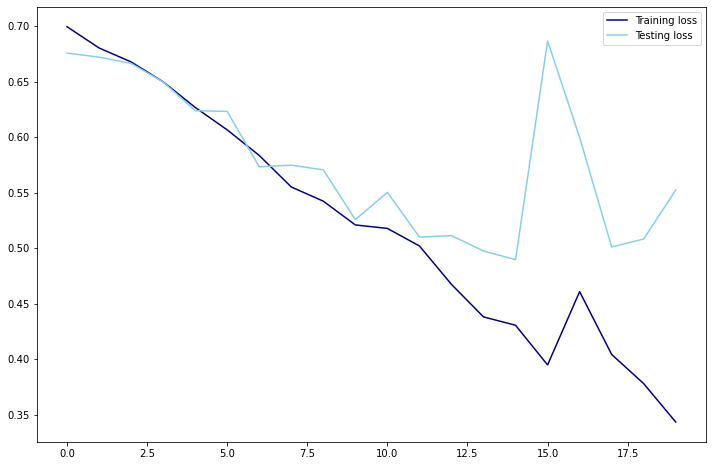

In [36]:
# Visualize the loss
train_loss = model_1.history['loss']
test_loss = model_1.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

## Early Stopping

In [37]:
model = Sequential()

# conv, pool
# 64 - n filters to use
# (3,3) - dimensions of each filter - pretty arbitrary here 
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(64,64,1)))
model.add(MaxPooling2D(pool_size=(2,2)))

# conv, pool
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# flatten
model.add(Flatten())
model.add(Dense(64, activation='relu'))

# output
model.add(Dense(1, activation='sigmoid'))

# compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

In [38]:
#model = getModel()
#model.summary()
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
batch_size = 64

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

model_res = model.fit(X_train, y_train, batch_size=64, epochs=20, verbose=1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_data=(X_test, y_test))

Train on 655 samples, validate on 107 samples
Epoch 1/20
655/655 [==============================] - 7s 11ms/sample - loss: 0.6897 - accuracy: 0.5466 - auc_1: 0.5050 - val_loss: 0.6764 - val_accuracy: 0.5794 - val_auc_1: 0.6011
Epoch 2/20
655/655 [==============================] - 6s 9ms/sample - loss: 0.6732 - accuracy: 0.5817 - auc_1: 0.5795 - val_loss: 0.6679 - val_accuracy: 0.5794 - val_auc_1: 0.6251
Epoch 3/20
655/655 [==============================] - 6s 9ms/sample - loss: 0.6578 - accuracy: 0.6107 - auc_1: 0.6392 - val_loss: 0.6886 - val_accuracy: 0.5794 - val_auc_1: 0.6371
Epoch 4/20
655/655 [==============================] - 6s 9ms/sample - loss: 0.6443 - accuracy: 0.6489 - auc_1: 0.6636 - val_loss: 0.6366 - val_accuracy: 0.6542 - val_auc_1: 0.6797
Epoch 5/20
655/655 [==============================] - 6s 9ms/sample - loss: 0.6208 - accuracy: 0.6641 - auc_1: 0.7037 - val_loss: 0.6186 - val_accuracy: 0.6449 - val_auc_1: 0.7091
Epoch 6/20
655/655 [==============================] -

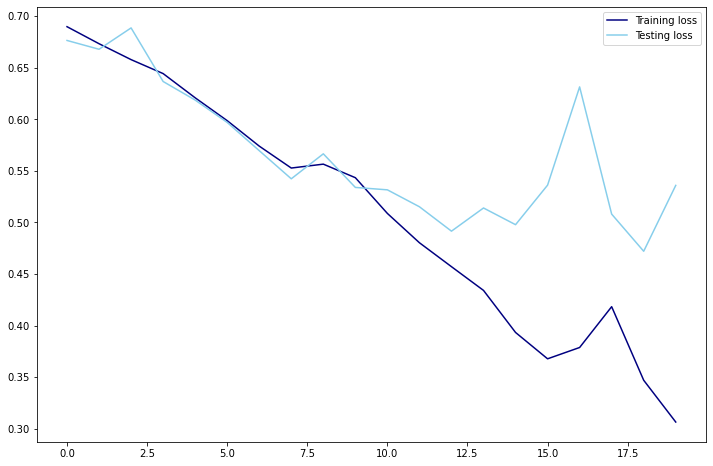

In [39]:
# Visualize the loss
train_loss = model_res.history['loss']
test_loss = model_res.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

In [40]:
preds=model.predict(X_test)

In [41]:
metrics.confusion_matrix(y_test, preds.round())

array([[27, 18],
       [ 6, 56]])

In [42]:
model_best = tf.keras.models.load_model('.mdl_wts.hdf5')

In [43]:
preds_best=model.predict(X_test)

In [44]:
metrics.confusion_matrix(y_test, preds_best.round())

array([[27, 18],
       [ 6, 56]])

## Model-2: Dropout Regularization

In [45]:
# Import a Dropout layer
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

# Build a model using Dropout

# Model
model_dropout = Sequential()

model_dropout.add(Conv2D(32, (3,3), activation='relu', input_shape=(64,64,1)))
model_dropout.add(MaxPooling2D(pool_size=(2,2)))
model_dropout.add(Dropout(0.2))

# conv, pool
model_dropout.add(Conv2D(64, (3,3), activation='relu'))
model_dropout.add(MaxPooling2D(pool_size=(2,2)))
#model_dropout.add(Dropout(0.5))

# flatten
model_dropout.add(Flatten())
model_dropout.add(Dense(64, activation='relu'))
#model_dropout.add(Dropout(0.4))

# output
model_dropout.add(Dense(1, activation='sigmoid'))

#  Compile the model
model_dropout.compile(loss=bce, optimizer='adam', metrics=['acc', tf.keras.metrics.AUC()])


In [46]:
batch_size = 64

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts_dropout.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

# Fit it
results_dropout = model_dropout.fit(X_train, y_train, batch_size=batch_size, epochs=20, verbose=1, 
                                    callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_data=(X_test, y_test))

Train on 655 samples, validate on 107 samples
Epoch 1/20
655/655 [==============================] - 8s 11ms/sample - loss: 0.8104 - acc: 0.4702 - auc_2: 0.4586 - val_loss: 0.7031 - val_acc: 0.4206 - val_auc_2: 0.4706
Epoch 2/20
655/655 [==============================] - 6s 10ms/sample - loss: 0.6984 - acc: 0.4977 - auc_2: 0.4956 - val_loss: 0.6908 - val_acc: 0.5794 - val_auc_2: 0.5441
Epoch 3/20
655/655 [==============================] - 6s 10ms/sample - loss: 0.6871 - acc: 0.5817 - auc_2: 0.5272 - val_loss: 0.6874 - val_acc: 0.5794 - val_auc_2: 0.5534
Epoch 4/20
655/655 [==============================] - 6s 10ms/sample - loss: 0.6826 - acc: 0.5817 - auc_2: 0.4868 - val_loss: 0.6802 - val_acc: 0.5794 - val_auc_2: 0.5507
Epoch 5/20
655/655 [==============================] - 6s 10ms/sample - loss: 0.6803 - acc: 0.5817 - auc_2: 0.5008 - val_loss: 0.6790 - val_acc: 0.5794 - val_auc_2: 0.5557
Epoch 6/20
655/655 [==============================] - 6s 10ms/sample - loss: 0.6792 - acc: 0.5817 -

In [47]:
# Visualize loss
train_loss_dropout = results_dropout.history['loss']
test_loss_dropout = results_dropout.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.plot(train_loss_dropout, label='Dropout Training loss', color='darkgreen')
plt.plot(test_loss_dropout, label='Dropout Testing loss', color='lightgreen')
plt.legend();

In [48]:
# Calculate the average loss
np.mean(results_dropout.history['loss'])

0.6618355863353678

## Model-3: Regularization Method 1: L1 and L2

Recall the key difference: L1 penalties perform selection. That is, they often zero out parameters when they're small enough. While this sounds appealing, L2 is used almost exclusively. It's done so often, that deep learning practitions give it a special name: weight decay.

In [49]:
# Import regularizers
from tensorflow.keras.regularizers import l2

# Model
model_l2 = Sequential()

model_l2.add(Conv2D(32, (3,3), activation='relu', input_shape=(64,64,1)))
model_l2.add(MaxPooling2D(pool_size=(2,2)))
model_l2.add(Dropout(0.2))

# conv, pool
model_l2.add(Conv2D(64, (3,3), activation='relu'))
model_l2.add(MaxPooling2D(pool_size=(2,2)))
#model_l2.add(Dropout(0.5))

# flatten
model_l2.add(Flatten())
model_l2.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
#model_l2.add(Dropout(0.4))

# output
model_l2.add(Dense(1, activation='sigmoid'))

#  Compile the model
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model_l2.compile(loss=bce, optimizer=optimizer, metrics=['acc', tf.keras.metrics.AUC()])

In [50]:
batch_size = 64

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts_dropout_l2.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

# Fit it
results_l2 = model_l2.fit(X_train, y_train, batch_size=batch_size, epochs=20, verbose=1, 
                                    callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_data=(X_test, y_test))

Train on 655 samples, validate on 107 samples
Epoch 1/20
655/655 [==============================] - 7s 11ms/sample - loss: 0.8282 - acc: 0.5084 - auc_3: 0.4597 - val_loss: 0.7521 - val_acc: 0.5794 - val_auc_3: 0.5093
Epoch 2/20
655/655 [==============================] - 6s 10ms/sample - loss: 0.7390 - acc: 0.5817 - auc_3: 0.5116 - val_loss: 0.7289 - val_acc: 0.5794 - val_auc_3: 0.5545
Epoch 3/20
655/655 [==============================] - 6s 10ms/sample - loss: 0.7217 - acc: 0.5817 - auc_3: 0.5454 - val_loss: 0.7184 - val_acc: 0.5794 - val_auc_3: 0.6116
Epoch 4/20
655/655 [==============================] - 6s 10ms/sample - loss: 0.7126 - acc: 0.5817 - auc_3: 0.5388 - val_loss: 0.7084 - val_acc: 0.5794 - val_auc_3: 0.5957
Epoch 5/20
655/655 [==============================] - 6s 10ms/sample - loss: 0.7010 - acc: 0.5863 - auc_3: 0.6050 - val_loss: 0.6990 - val_acc: 0.5981 - val_auc_3: 0.6319
Epoch 6/20
655/655 [==============================] - 6s 10ms/sample - loss: 0.6904 - acc: 0.5985 -

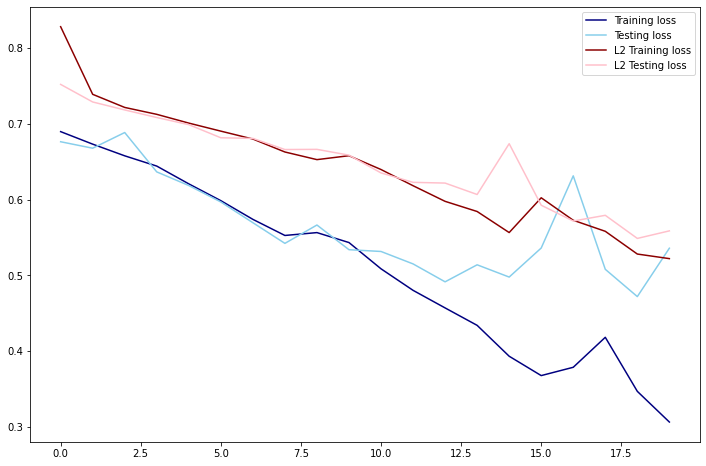

In [51]:
# Visualize loss
train_loss_l2 = results_l2.history['loss']
test_loss_l2 = results_l2.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.plot(train_loss_l2, label='L2 Training loss', color='darkred')
plt.plot(test_loss_l2, label='L2 Testing loss', color='pink')
plt.legend();

####  Model-1: Convolutional Neural Network (CNN) is the best with one with good score.
